<a href="https://colab.research.google.com/github/nadine721/currency-classifier-dataset/blob/main/splitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import shutil
import os
import math

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)



Mounted at /content/gdrive
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected


In [ ]:
#path configuration
parent_dir = '/content/gdrive/MyDrive/Final Dataset'

#get category folder list
os.chdir(parent_dir)
category_list = list(filter(lambda x: os.path.isdir(x), os.listdir()))
for category in category_list:
  print(category)

5000
10000
2000
25
500
100
50
1000


In [ ]:
# now to creating my training,testing,validation directories
data_set_dirs= ['train','valid','test']
for dsdirs in data_set_dirs:
  path = parent_dir + '/'+ dsdirs 
  if os.path.isdir(path):
    print('file directory exist')
  else:
    os.mkdir( path,755)


In [ ]:
#define proportion of data
train_prop = 0.8
valid_prop = test_prop = (1-train_prop)/2
#function to split data of each category into trainning, validation and testing set
def create_dataset():
  for ii,cat in enumerate(category_list):    
    src_path = parent_dir + '/' + cat
    dest_dir1 = parent_dir+'/train/'+str(ii)
    dest_dir2 = parent_dir+'/valid/'+str(ii)
    dest_dir3 = parent_dir+'/test/'+str(ii)


    dest_dirs_list = [dest_dir1,dest_dir2,dest_dir3]
    for dirs in dest_dirs_list:
      os.mkdir(dirs,755 )
    
    #get files' names list from respective directories
    os.chdir(src_path)
    files = [f for f in os.listdir() if os.path.isfile(f)]
    
    #get training, testing and validation files count
    train_count = math.ceil(train_prop*len(files))
    valid_count = int((len(files)-train_count)/2)
    test_count = valid_count
    
    #get files to segragate for train,test and validation data set
    train_data_list = files[0: train_count]
    valid_data_list = files[train_count+1:train_count+1+valid_count]  
    test_data_list =  files[train_count+valid_count:]
       
  
    for train_data in train_data_list:
      train_path = src_path + '/' + train_data
      shutil.copy(train_path,dest_dir1)
    
    for valid_data in valid_data_list:
      valid_path = src_path + '/' + valid_data
      shutil.copy(valid_path,dest_dir2)
    
    for test_data in test_data_list:
      test_path = src_path + '/' + test_data
      shutil.copy(test_path,dest_dir3)

create_dataset()

In [ ]:

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/Final Dataset/train'
valid_path = '/content/gdrive/MyDrive/Final Dataset/test'

In [ ]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [ ]:
# useful for getting number of output classes
folders = glob('/content/gdrive/MyDrive/Final Dataset/train/*')

In [ ]:
# our layers - you can add more if you want
x = Flatten()(resnet.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:

# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Final Dataset/train/',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 646 images belonging to 8 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('/content/gdrive/MyDrive/Final Dataset/test/',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 80 images belonging to 8 classes.


In [ ]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
21/21 [==============================] - 90s 4s/step - loss: 9.8473 - accuracy: 0.1388 - val_loss: 8.1372 - val_accuracy: 0.1000
Epoch 2/20
21/21 [==============================] - 82s 4s/step - loss: 4.9466 - accuracy: 0.2169 - val_loss: 2.8024 - val_accuracy: 0.0250
Epoch 3/20
21/21 [==============================] - 82s 4s/step - loss: 2.0965 - accuracy: 0.3660 - val_loss: 2.4198 - val_accuracy: 0.3500
Epoch 4/20
21/21 [==============================] - 82s 4s/step - loss: 1.7821 - accuracy: 0.3715 - val_loss: 2.4002 - val_accuracy: 0.2875
Epoch 5/20
21/21 [==============================] - 82s 4s/step - loss: 1.5522 - accuracy: 0.4942 - val_loss: 2.2094 - val_accuracy: 0.2125
Epoch 6/20
21/21 [==============================] - 82s 4s/step - loss: 1.4263 - accuracy: 0.5434 - val_loss: 2.0928 - val_accuracy: 0.4000
Epoch 7/20
21/21 [==============================] - 82s 4s/step - loss: 1.2868 - accuracy: 0.5552 - val_loss: 2.5992 - val_accuracy: 0.2750
Epoch 8/20
21/21 [==

In [ ]:
import matplotlib.pyplot as plt

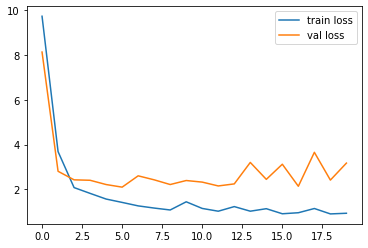

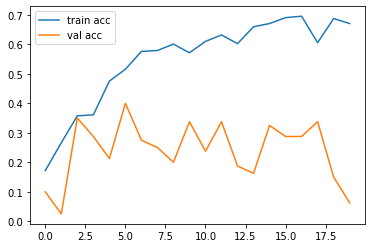

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_resnet50.h5')